In [1]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
import re
from gensim.test.utils import datapath
from gensim.models.fasttext import *
import gensim.downloader as api
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
cap_path = datapath(os.getcwd() + "/data/cc.en.300.bin.gz")
fbkv = load_facebook_vectors(cap_path)

In [3]:
w2v = api.load("word2vec-google-news-300") 

In [4]:
tokenizer = AutoTokenizer.from_pretrained("roberta-large")
model = AutoModelWithLMHead.from_pretrained("roberta-large")

In [127]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':100})

In [133]:
def lget(lst, pos):
    return list(map(lambda x: x[pos], lst))

def dget(lst, pos):    
    return list(map(lambda x: '{0:.2f}'.format(x[pos]), lst))

def mk_graph(x1, x2):
    x1 = list(filter(lambda x: x > -2 and x < 0.99, x1))[:20]
    x2 = list(filter(lambda x: x > -2 and x < 0.99, x2))[:20]
    kwargs = dict(alpha=0.3, bins=20)

    plt.hist(x1, **kwargs, color='g', label='FastText score')
    plt.hist(x2, **kwargs, color='b', label='Word2Vec score')
    plt.gca().set(title='Top 20 masks histogram of embeddings score', ylabel='Count')

    plt.legend()
    plt.show()

def find_top(sentence, k, min_sim): 
    print("Input: ", sentence)
    smatch = re.search("(\w+)\?", sentence)
    target = None
    
    if (smatch):
        target = re.sub("\?", "", smatch.group(0))
        target = target.strip()
        
    sequence = re.sub("(\w+)?\?", tokenizer.mask_token, sentence)
    print(tokenizer.tokenize(sequence))
    
    input = tokenizer.encode(sequence, return_tensors="pt")
    mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

    token_logits = model(input)[0]
    mask_token_logits = token_logits[0, mask_token_index, :]

    topk = torch.topk(mask_token_logits, tokenizer.vocab_size, dim=1)
    top_tokens = list(zip(topk.indices[0].tolist(), topk.values[0].tolist()))

    unfiltered = list()
    filtered = list()
    
    for token, value in top_tokens:
        word = tokenizer.decode([token]).strip()
        sim = None

        sim = fbkv.similarity(target, word)
        try:
            sim2 = w2v.similarity(target, word)
        except:
            sim2 = -2

        if (sim >= min_sim and sim2 >= min_sim):
            filtered.append((word, value, sim, sim2))
                
        unfiltered.append((word, value, sim, sim2))
        
    kfiltered = filtered[:k]
    kunfiltered = unfiltered[:k]

    print(pd.DataFrame({
        'word': lget(kunfiltered, 0),
        'bert': dget(kunfiltered, 1),
        'ftext': dget(kunfiltered, 2),
        'w2vec': dget(kunfiltered, 3),
    }))
    
    print(pd.DataFrame({
        'word': lget(kfiltered, 0),
        'bert': dget(kfiltered, 1),
        'ftext': dget(kfiltered, 2),
        'w2vec': dget(kfiltered, 3),
    }))
    
    mk_graph(lget(unfiltered, 2)[:100], lget(unfiltered, 3)[:100])
        
    if (target != None):
        vec = tokenizer.encode(target, return_tensors="pt")[0]
        if (len(vec) == 3):
            tk = vec[1].item()
            pos = None
            score = None
            
            for e, (t, v) in enumerate(top_tokens):
                if (t == tk):
                    pos = e
                    score = v
                    break
            print("Original word position: ", e, "; score: ", score)
        else: 
            if (len(vec) > 3):
                print("Original word is more then 1 token")
                print(tokenizer.tokenize(target))
            else:
                print("Original word wasn't found")
    print("===================")
    
def do_find(s, min_sim = 0.25):
    find_top(s, 20, min_sim) 
    
base_samples = [
    "what's the local weather? forecast",
    "chance of rain? tomorrow in Moscow",
    "chance of rain? tomorrow",
    "set the lights? on in the entire house",
    "set the lights on in the entire house?",
    "turn the lights off in the guest? bedroom",
    "turn the lights off in the guest bedroom?"
]

## Random wiki how to articles
articles = [
    "how to use a sharpening steel?",
    "how to identify? and treat liver shunts in cats",
    "how to identify and treat? liver shunts in cats",
    "how to identify and treat liver? shunts in cats",
    "use enamel paint? on a stove",
    "escape a sinking? ship",
    "escape a sinking ship?",
    "reduce the effect? of macular degeneration",
    "recognize sign? of an abusive person",
    "recognize signs of an abusive person?",
    "make wine? vinegar",
    "prepare boneless skinless chicken? thighs",
    "what can you eat with type 2 diabetes?"
]

Input:  what's the local weather? forecast
['what', "'s", 'Ġthe', 'Ġlocal', '<mask>', 'Ġforecast']
             word   bert ftext w2vec
0         weather  58.94  1.00  1.00
1     temperature  55.83  0.45  0.39
2            snow  55.37  0.49  0.52
3         traffic  54.94  0.32  0.28
4        rainfall  54.86  0.50  0.47
5            rain  54.68  0.58  0.57
6          school  54.50  0.16  0.08
7         weekend  54.44  0.35  0.27
8   precipitation  54.29  0.41  0.47
9         driving  54.14  0.22  0.19
10         travel  53.82  0.26  0.24
11           fire  53.77  0.25  0.23
12          radar  53.73  0.32  0.23
13        tornado  53.73  0.34  0.32
14          storm  53.71  0.50  0.50
15        eclipse  53.69  0.18  0.20
16           heat  53.66  0.37  0.33
17        heating  53.61  0.29  0.28
18         winter  53.39  0.55  0.55
19        morning  53.34  0.30  0.25
             word   bert ftext w2vec
0         weather  58.94  1.00  1.00
1     temperature  55.83  0.45  0.39
2            

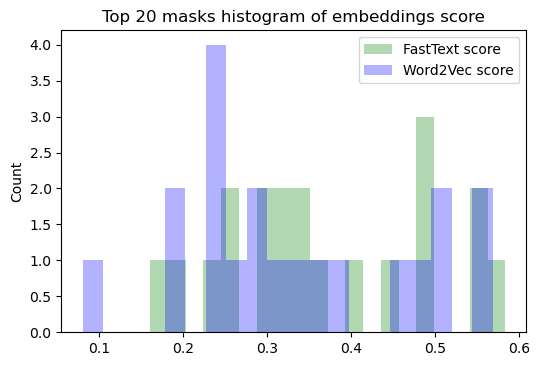

Original word position:  0 ; score:  58.944068908691406
Input:  chance of rain? tomorrow in Moscow
['chance', 'Ġof', '<mask>', 'Ġtomorrow', 'Ġin', 'ĠMoscow']
          word   bert ftext w2vec
0     protests  56.42  0.13  0.14
1        Putin  55.87  0.01  0.03
2      protest  55.55  0.14  0.10
3     Olympics  54.79  0.08  0.01
4        peace  54.64  0.12  0.15
5       Terror  54.45  0.04  0.09
6       events  54.42  0.12  0.15
7       Russia  54.28  0.00  0.02
8        march  54.19  0.23  0.18
9    fireworks  54.10  0.28  0.24
10  Revolution  54.09  0.07  0.12
11     rallies  53.99  0.13  0.18
12   emergency  53.95  0.15  0.10
13    violence  53.88  0.19  0.16
14      speech  53.81  0.11  0.01
15  revolution  53.81  0.08  0.04
16    Congress  53.81  0.01  0.01
17  Parliament  53.79  0.04  0.01
18       Lenin  53.69  0.03  0.04
19        life  53.65  0.16  0.11
         word   bert ftext w2vec
0      winter  52.43  0.39  0.32
1        snow  51.79  0.59  0.63
2     gunfire  51.70  0.28  0

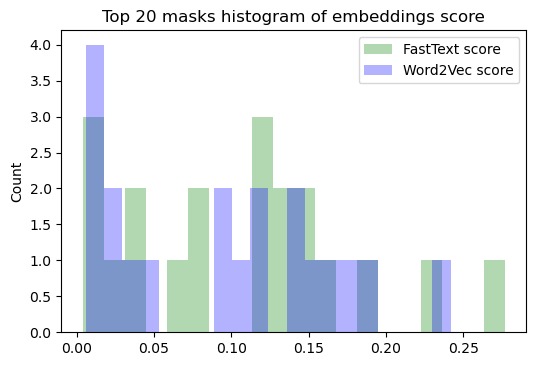

Original word position:  354 ; score:  50.88834762573242
Input:  chance of rain? tomorrow
['chance', 'Ġof', '<mask>', 'Ġtomorrow']
             word   bert ftext w2vec
0            rain  59.15  1.00  1.00
1            snow  58.66  0.59  0.63
2         showers  57.47  0.50  0.67
3          storms  57.34  0.55  0.51
4            Rain  56.86  0.69  0.75
5           storm  56.51  0.56  0.46
6             day  56.40  0.28  0.23
7         weather  56.38  0.58  0.57
8        sunshine  56.30  0.53  0.51
9             fog  56.27  0.50  0.51
10           work  56.16  0.09  0.11
11            sun  56.15  0.47  0.43
12           this  55.92  0.12  0.19
13           cold  55.81  0.41  0.34
14            Day  55.71  0.15  0.14
15        eclipse  55.60  0.21  0.17
16         school  55.55  0.11  0.10
17             it  55.55  0.18  0.15
18  precipitation  55.45  0.59  0.69
19       rainfall  55.43  0.67  0.71
             word   bert ftext w2vec
0            rain  59.15  1.00  1.00
1            snow 

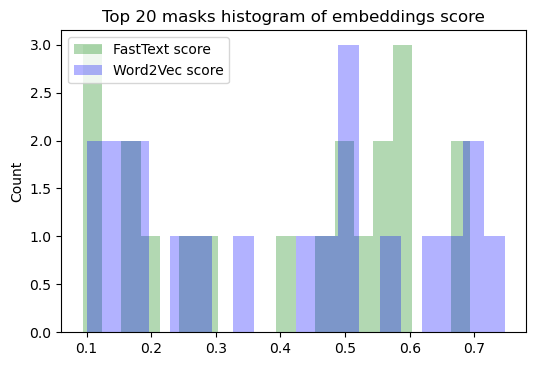

Original word position:  0 ; score:  59.147621154785156
Input:  set the lights? on in the entire house
['set', 'Ġthe', '<mask>', 'Ġon', 'Ġin', 'Ġthe', 'Ġentire', 'Ġhouse']
           word   bert ftext w2vec
0        lights  61.43  1.00  1.00
1          heat  60.00  0.25  0.26
2            AC  58.90  0.17  0.18
3         light  58.84  0.63  0.55
4          fans  58.79  0.20  0.16
5         water  58.60  0.22  0.19
6           fan  58.24  0.15  0.08
7       heating  58.15  0.26  0.28
8   electricity  58.08  0.36  0.32
9         power  57.69  0.29  0.25
10           TV  57.68  0.17  0.16
11      furnace  56.99  0.23  0.27
12       heater  56.83  0.32  0.33
13        stove  56.83  0.28  0.31
14         oven  56.71  0.24  0.22
15          air  56.55  0.22  0.11
16   television  56.38  0.21  0.14
17        lamps  56.34  0.68  0.58
18        music  56.13  0.24  0.16
19     lighting  56.02  0.71  0.67
           word   bert ftext w2vec
0        lights  61.43  1.00  1.00
1         light  58.84 

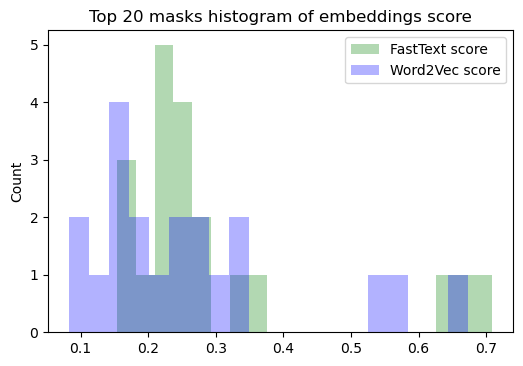

Original word position:  0 ; score:  61.43402862548828
Input:  set the lights on in the entire house?
['set', 'Ġthe', 'Ġlights', 'Ġon', 'Ġin', 'Ġthe', 'Ġentire', '<mask>']
          word   bert ftext w2vec
0         room  63.75  0.51  0.46
1        house  63.09  1.00  1.00
2     building  61.14  0.51  0.44
3         area  60.70  0.32  0.29
4       office  60.46  0.39  0.32
5     basement  60.36  0.59  0.49
6      kitchen  60.34  0.48  0.47
7    apartment  60.14  0.65  0.66
8     bathroom  60.08  0.45  0.39
9        store  60.07  0.32  0.32
10         car  59.98  0.44  0.39
11     theater  59.97  0.29  0.24
12        home  59.97  0.65  0.56
13       cabin  59.91  0.50  0.45
14   classroom  59.67  0.26  0.27
15        shop  59.66  0.38  0.38
16   warehouse  59.56  0.39  0.41
17  restaurant  59.55  0.37  0.32
18     hallway  59.52  0.39  0.29
19       place  59.52  0.39  0.19
          word   bert ftext w2vec
0         room  63.75  0.51  0.46
1        house  63.09  1.00  1.00
2     buildi

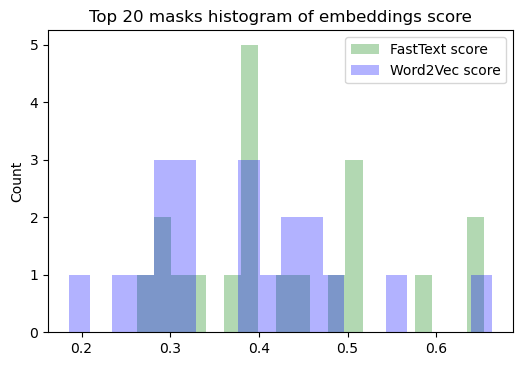

Original word position:  1 ; score:  63.09485626220703
Input:  turn the lights off in the guest? bedroom
['turn', 'Ġthe', 'Ġlights', 'Ġoff', 'Ġin', 'Ġthe', '<mask>', 'Ġbedroom']
          word   bert ftext w2vec
0       master  62.26  0.26  0.17
1        guest  60.63  1.00  1.00
2       second  59.89  0.21  0.09
3        spare  59.19  0.18  0.11
4        third  58.97  0.24  0.09
5         main  58.72  0.24  0.10
6         back  58.61  0.12  0.01
7     upstairs  58.48  0.30  0.21
8        other  58.33  0.19  0.12
9        front  58.01  0.18  0.09
10  downstairs  57.80  0.28  0.21
11      middle  57.33  0.07  0.01
12       first  57.30  0.26  0.09
13       extra  56.93  0.26  0.10
14      Master  56.86  0.16  0.16
15        next  56.62  0.21  0.09
16        last  56.50  0.20  0.09
17      fourth  56.48  0.22  0.07
18      family  56.44  0.28  0.13
19   adjoining  56.27  0.23  0.15
         word   bert ftext w2vec
0       guest  60.63  1.00  1.00
1      guests  54.34  0.68  0.62
2       h

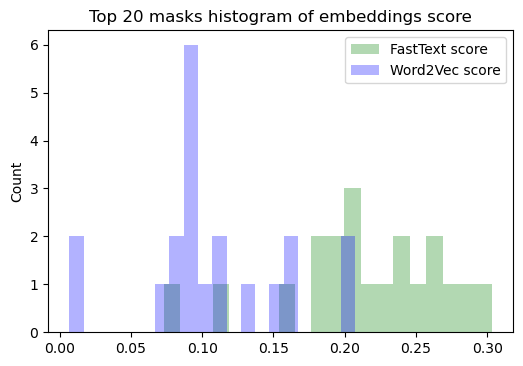

Original word position:  1 ; score:  60.62987518310547
Input:  turn the lights off in the guest bedroom?
['turn', 'Ġthe', 'Ġlights', 'Ġoff', 'Ġin', 'Ġthe', 'Ġguest', '<mask>']
         word   bert ftext w2vec
0        room  62.96  0.60  0.51
1       rooms  61.59  0.50  0.48
2     bedroom  61.55  1.00  1.00
3    bathroom  60.76  0.70  0.62
4        room  60.06  0.60  0.51
5    bedrooms  59.71  0.76  0.78
6       rooms  59.17  0.50  0.48
7        bath  58.99  0.59  0.55
8        area  58.70  0.25  0.20
9       house  58.14  0.57  0.65
10      cabin  58.14  0.38  0.46
11      house  58.11  0.57  0.65
12   quarters  58.04  0.33  0.23
13      areas  57.98  0.19  0.14
14        bed  57.82  0.60  0.52
15      suite  57.81  0.49  0.32
16  bathrooms  57.79  0.55  0.46
17     suites  57.06  0.42  0.33
18   restroom  56.88  0.35  0.32
19     lounge  56.86  0.46  0.33
         word   bert ftext w2vec
0        room  62.96  0.60  0.51
1       rooms  61.59  0.50  0.48
2     bedroom  61.55  1.00  1.00

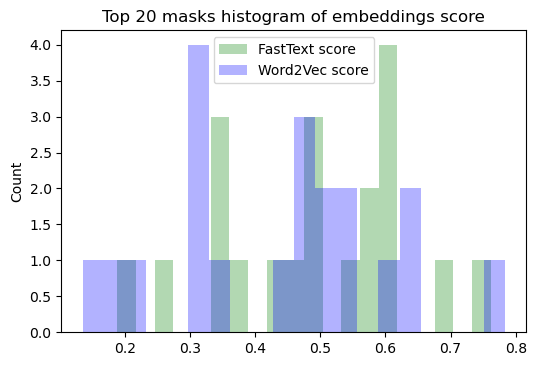

Original word position:  2 ; score:  61.55071258544922


In [134]:
for s in base_samples:
    do_find(s)

Input:  how to use a sharpening steel?
['how', 'Ġto', 'Ġuse', 'Ġa', 'Ġsharp', 'ening', '<mask>']
          word   bert ftext w2vec
0         tool  55.64  0.19  0.04
1        knife  55.37  0.33  0.10
2       pencil  55.19  0.26  0.13
3         iron  54.96  0.59  0.45
4        stone  54.87  0.42  0.32
5        wheel  54.34  0.28  0.16
6          pen  53.86  0.22  0.06
7       device  53.61  0.10  0.05
8        brush  53.13  0.21  0.06
9        blade  52.89  0.39  0.24
10         tip  52.83  0.18  0.07
11       stick  52.60  0.21  0.08
12         pin  52.42  0.22  0.11
13       board  52.18  0.14  0.00
14       spoon  52.13  0.27  0.14
15         bar  52.10  0.28  0.12
16       steel  52.06  1.00  1.00
17       press  52.03  0.09  0.12
18     surface  52.01  0.24  0.11
19  instrument  51.97  0.21  0.16
        word   bert ftext w2vec
0       iron  54.96  0.59  0.45
1      stone  54.87  0.42  0.32
2      steel  52.06  1.00  1.00
3       wire  51.95  0.45  0.30
4        rod  51.72  0.43  0.

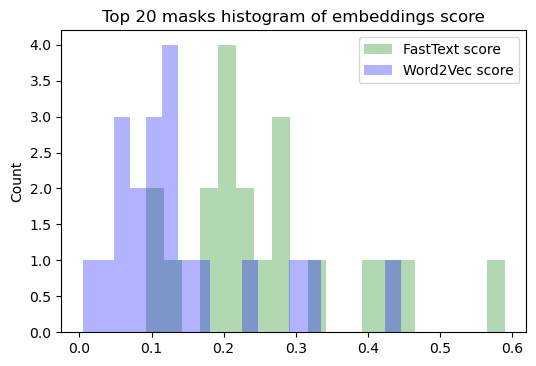

Original word position:  16 ; score:  52.06224060058594
Input:  how to identify? and treat liver shunts in cats
['how', 'Ġto', '<mask>', 'Ġand', 'Ġtreat', 'Ġliver', 'Ġshun', 'ts', 'Ġin', 'Ġcats']
         word   bert ftext w2vec
0    diagnose  61.97  0.51  0.47
1        spot  60.44  0.28  0.10
2     prevent  60.22  0.41  0.29
3    identify  59.71  1.00  1.00
4      detect  59.45  0.62  0.56
5        find  59.16  0.53  0.51
6   recognize  58.66  0.61  0.53
7     monitor  57.19  0.40  0.38
8       catch  57.06  0.28  0.25
9      locate  56.84  0.63  0.65
10      avoid  56.64  0.40  0.25
11  diagnosis  56.41  0.20  0.15
12    predict  56.21  0.48  0.36
13   evaluate  56.10  0.61  0.50
14     assess  56.01  0.66  0.51
15   discover  55.95  0.49  0.49
16       view  55.91  0.20  0.16
17        see  55.89  0.40  0.34
18    isolate  55.86  0.54  0.45
19       test  55.66  0.24  0.19
           word   bert ftext w2vec
0      diagnose  61.97  0.51  0.47
1       prevent  60.22  0.41  0.29
2     

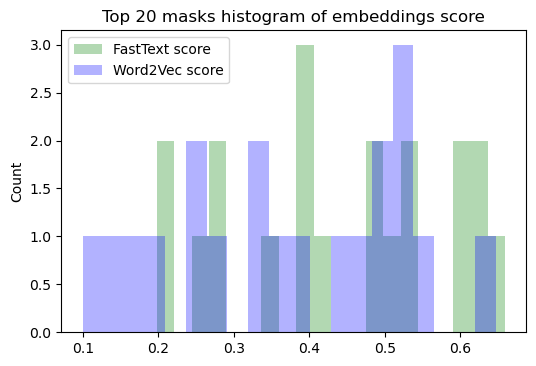

Original word position:  3 ; score:  59.7053337097168
Input:  how to identify and treat? liver shunts in cats
['how', 'Ġto', 'Ġidentify', 'Ġand', '<mask>', 'Ġliver', 'Ġshun', 'ts', 'Ġin', 'Ġcats']
        word   bert ftext w2vec
0      treat  62.70  1.00  1.00
1     manage  59.27  0.34  0.31
2    prevent  59.01  0.41  0.24
3     repair  58.93  0.14  0.13
4     remove  58.88  0.23  0.25
5   diagnose  58.35  0.49  0.49
6      track  57.80  0.14  0.11
7       stop  57.51  0.31  0.16
8    monitor  57.48  0.20  0.28
9       cure  57.31  0.41  0.39
10       fix  57.18  0.29  0.26
11   control  57.12  0.12  0.13
12    detect  56.89  0.32  0.35
13    induce  56.84  0.31  0.25
14   measure  56.67  0.22  0.20
15   correct  56.65  0.13  0.10
16   restore  56.65  0.22  0.20
17      heal  56.64  0.36  0.37
18  evaluate  56.52  0.31  0.39
19   address  56.52  0.18  0.23
          word   bert ftext w2vec
0        treat  62.70  1.00  1.00
1       manage  59.27  0.34  0.31
2     diagnose  58.35  0.49  

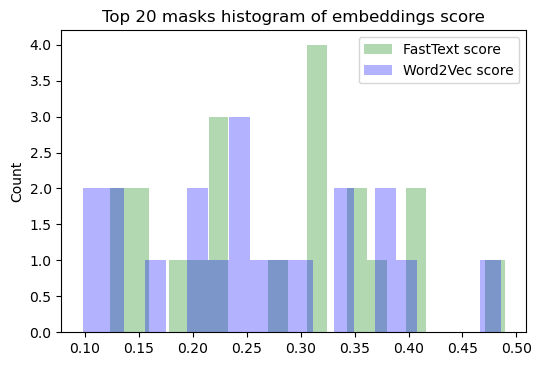

Original word position:  0 ; score:  62.69602584838867
Input:  how to identify and treat liver? shunts in cats
['how', 'Ġto', 'Ġidentify', 'Ġand', 'Ġtreat', '<mask>', 'Ġshun', 'ts', 'Ġin', 'Ġcats']
           word   bert ftext  w2vec
0       urinary  57.67  0.39   0.45
1          tail  56.33  0.25   0.18
2       thyroid  56.21  0.53   0.51
3           ear  55.92  0.25   0.25
4          head  55.73  0.15   0.05
5   respiratory  55.55  0.37   0.42
6         heart  55.48  0.41   0.45
7         liver  55.42  1.00   1.00
8    intestinal  55.39  0.51   0.55
9         nasal  55.31  0.22   0.35
10         neck  55.26  0.28   0.24
11        spine  55.13  0.28   0.37
12      bladder  54.98  0.42   0.51
13          the  54.98  0.14  -0.02
14       spinal  54.95  0.30   0.45
15        blood  54.92  0.40   0.42
16      chronic  54.90  0.37   0.30
17          bed  54.89  0.16   0.20
18         anal  54.82  0.22   0.25
19   autoimmune  54.81  0.40   0.47
           word   bert ftext w2vec
0       uri

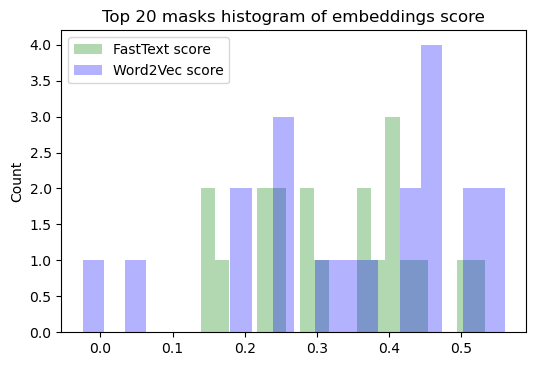

Original word position:  7 ; score:  55.418087005615234
Input:  use enamel paint? on a stove
['use', 'Ġen', 'amel', '<mask>', 'Ġon', 'Ġa', 'Ġstove']
        word   bert  ftext w2vec
0        pot  56.88   0.24  0.12
1        pan  56.84   0.21  0.13
2       pots  56.63   0.31  0.20
3         ed  55.75  -0.04  0.03
4       pans  55.69   0.23  0.19
5       jars  55.53   0.25  0.13
6    coating  55.35   0.45  0.35
7        jar  54.92   0.24  0.15
8        oil  54.79   0.35  0.18
9      paint  54.75   1.00  1.00
10       ing  54.69   0.12  0.01
11      dish  54.54   0.14  0.11
12      oven  54.51   0.17  0.11
13    paints  54.43   0.75  0.66
14  painting  54.28   0.70  0.54
15      tray  54.15   0.19  0.07
16       egg  54.09   0.22  0.15
17     sauce  54.05   0.27  0.15
18      ware  54.03   0.21  0.16
19     tubes  54.02   0.21  0.13
        word   bert ftext w2vec
0    coating  55.35  0.45  0.35
1      paint  54.75  1.00  1.00
2     paints  54.43  0.75  0.66
3   painting  54.28  0.70  0.5

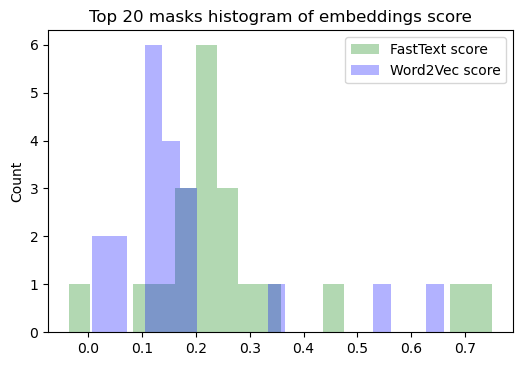

Original word position:  9 ; score:  54.7498779296875
Input:  escape a sinking? ship
['escape', 'Ġa', '<mask>', 'Ġship']
         word   bert ftext  w2vec
0      cruise  58.43  0.33   0.29
1       cargo  56.79  0.27   0.12
2      pirate  56.48  0.20   0.21
3     sinking  56.10  1.00   1.00
4   container  55.71  0.17   0.08
5       small  55.66  0.09   0.06
6        tall  55.66  0.12   0.11
7       ghost  55.46  0.15   0.18
8   passenger  55.33  0.19   0.07
9         new  55.23  0.12   0.07
10      space  54.91  0.06   0.06
11     rocket  54.86  0.18   0.18
12     mother  54.80  0.13   0.05
13      large  54.77  0.16   0.06
14    sailing  54.57  0.38   0.33
15        big  54.54  0.17   0.12
16   hospital  54.49  0.09  -0.00
17       Navy  54.35  0.24   0.21
18      slave  54.34  0.13   0.16
19       good  54.33  0.09   0.13
         word   bert ftext w2vec
0      cruise  58.43  0.33  0.29
1     sinking  56.10  1.00  1.00
2     sailing  54.57  0.38  0.33
3      rescue  54.28  0.26  0.25


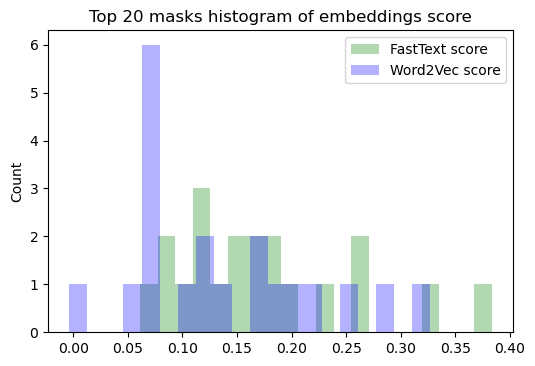

Original word position:  3 ; score:  56.103729248046875
Input:  escape a sinking ship?
['escape', 'Ġa', 'Ġsinking', '<mask>']
        word   bert ftext  w2vec
0       ship  61.24  1.00   1.00
1       boat  58.32  0.55   0.62
2     vessel  57.68  0.61   0.75
3      world  56.74  0.24   0.12
4    economy  56.64  0.21   0.15
5       city  56.41  0.18   0.04
6       Ship  56.07  0.61   0.67
7     planet  56.00  0.34   0.19
8      train  55.96  0.29   0.28
9    Titanic  55.90  0.46   0.43
10      star  55.81  0.19   0.04
11         ?  55.81  0.05  -2.00
12  building  55.57  0.24   0.18
13      town  55.57  0.19   0.08
14     house  55.49  0.22   0.18
15     state  55.45  0.12   0.07
16   feeling  55.37  0.03   0.10
17       man  55.27  0.14   0.06
18      dock  55.24  0.48   0.52
19     liner  55.23  0.32   0.27
         word   bert ftext w2vec
0        ship  61.24  1.00  1.00
1        boat  58.32  0.55  0.62
2      vessel  57.68  0.61  0.75
3        Ship  56.07  0.61  0.67
4       train  5

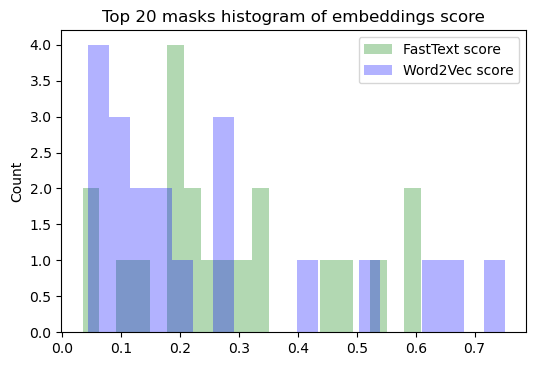

Original word position:  0 ; score:  61.24334716796875
Input:  reduce the effect? of macular degeneration
['red', 'uce', 'Ġthe', '<mask>', 'Ġof', 'Ġmac', 'ular', 'Ġdegener', 'ation']
           word   bert ftext w2vec
0        causes  57.66  0.36  0.22
1      symptoms  57.25  0.22  0.16
2         signs  57.17  0.19  0.15
3          risk  57.11  0.20  0.24
4       effects  56.85  0.75  0.64
5         onset  56.84  0.27  0.26
6         cause  56.33  0.42  0.28
7   progression  56.21  0.23  0.20
8       biology  56.03  0.06  0.07
9         risks  56.01  0.24  0.24
10   mechanisms  55.96  0.34  0.23
11      history  55.71  0.11  0.03
12      process  55.71  0.26  0.16
13       stages  55.56  0.09  0.10
14       impact  55.53  0.64  0.65
15      problem  55.17  0.26  0.22
16    beginning  55.07  0.19  0.24
17       course  55.05  0.18  0.12
18    pathology  54.97  0.11  0.09
19      disease  54.95  0.18  0.09
            word   bert ftext w2vec
0        effects  56.85  0.75  0.64
1         

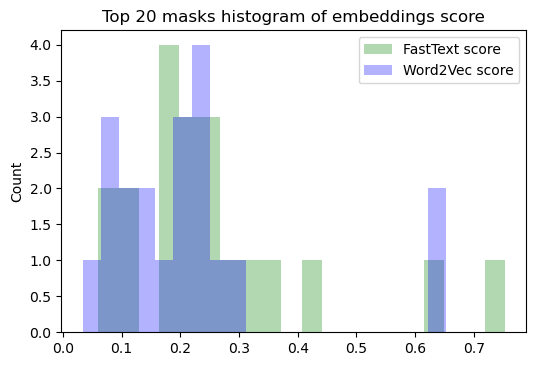

Original word position:  40 ; score:  54.533267974853516
Input:  recognize sign? of an abusive person
['recogn', 'ize', '<mask>', 'Ġof', 'Ġan', 'Ġabusive', 'Ġperson']
               word   bert  ftext  w2vec
0           essions  50.81   0.07  -2.00
1              life  50.07   0.07   0.02
2             eware  49.77   0.07  -2.00
3          behavior  49.76   0.15   0.09
4          reatment  49.64  -0.00  -2.00
5              rait  49.62   0.11  -2.00
6   characteristics  49.50   0.08   0.00
7          symptoms  49.41   0.20   0.18
8             signs  49.38   0.72   0.71
9              ence  49.19   0.02   0.00
10          actions  49.06   0.04  -0.00
11           victim  49.03   0.10   0.13
12           traits  48.95   0.13   0.09
13       definition  48.89   0.11   0.05
14                s  48.86   0.04  -0.02
15             sign  48.84   1.00   1.00
16             ives  48.70   0.10   0.02
17             face  48.66   0.20   0.18
18             fear  48.66   0.18   0.14
19          r

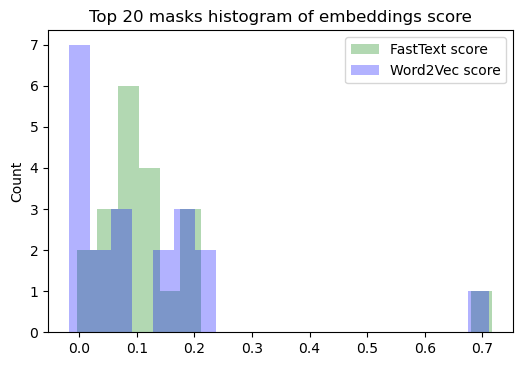

Original word position:  15 ; score:  48.83759307861328
Input:  recognize signs of an abusive person?
['recogn', 'ize', 'Ġsigns', 'Ġof', 'Ġan', 'Ġabusive', '<mask>']
             word   bert ftext  w2vec
0    relationship  63.47  0.27   0.07
1         partner  61.52  0.30   0.14
2          spouse  60.88  0.39   0.41
3        marriage  59.98  0.20   0.13
4       boyfriend  59.11  0.32   0.24
5         husband  58.80  0.34   0.27
6          parent  58.18  0.36   0.29
7       situation  57.74  0.29   0.19
8              ex  57.39  0.17  -0.02
9      girlfriend  57.34  0.33   0.23
10            man  57.29  0.56   0.53
11           wife  57.25  0.33   0.25
12    partnership  57.23  0.09   0.02
13          lover  57.01  0.33   0.27
14         father  56.80  0.30   0.23
15         person  56.78  1.00   1.00
16  relationships  56.63  0.19   0.06
17         couple  56.61  0.23   0.17
18        divorce  56.56  0.13   0.10
19         family  56.42  0.32   0.28
           word   bert ftext w2vec
0

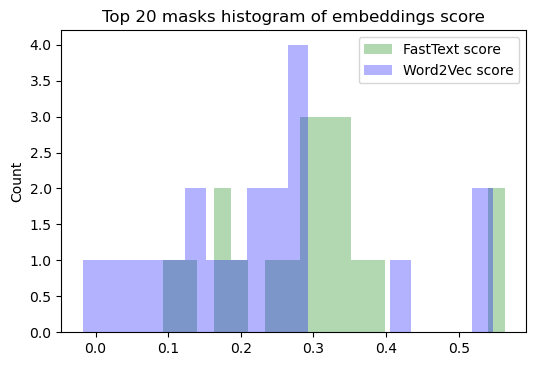

Original word position:  15 ; score:  56.78102111816406
Input:  make wine? vinegar
['make', '<mask>', 'Ġvinegar']
     word   bert ftext  w2vec
0     ine  49.17  0.14   0.11
1   herry  48.14  0.21  -2.00
2     and  47.98  0.20  -2.00
3   cider  47.56  0.53   0.52
4    rape  47.54  0.11   0.08
5   white  46.90  0.28   0.12
6      in  46.73  0.08   0.06
7    wine  46.52  1.00   1.00
8   emade  46.43  0.05  -2.00
9    ugar  46.27  0.16   0.05
10    ave  46.26  0.09   0.10
11    ise  46.23  0.06   0.06
12    ice  46.23  0.26   0.14
13     of  46.05  0.09  -2.00
14   amic  45.98  0.04  -2.00
15  apple  45.91  0.32   0.39
16     in  45.90  0.08   0.06
17   with  45.87  0.13   0.05
18     le  45.82  0.13   0.10
19   andy  45.81  0.06   0.08
         word   bert ftext w2vec
0       cider  47.56  0.53  0.52
1        wine  46.52  1.00  1.00
2       apple  45.91  0.32  0.39
3        rice  45.33  0.33  0.30
4   distilled  45.30  0.31  0.30
5        vine  45.08  0.44  0.39
6        malt  44.97  0.3

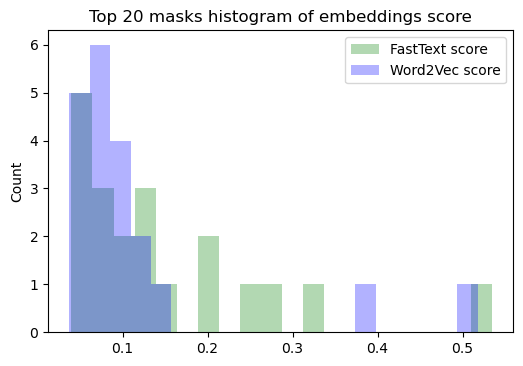

Original word position:  7 ; score:  46.52012252807617
Input:  prepare boneless skinless chicken? thighs
['prep', 'are', 'Ġbon', 'eless', 'Ġskin', 'less', '<mask>', 'Ġthighs']
          word   bert ftext w2vec
0        inner  58.67  0.18  0.05
1        upper  58.20  0.11  0.06
2        human  57.50  0.23  0.18
3       female  57.02  0.23  0.13
4         male  56.92  0.23  0.14
5         calf  56.75  0.36  0.28
6      chicken  56.71  1.00  1.00
7        lower  56.40  0.13  0.04
8        outer  55.81  0.19  0.09
9        hairy  55.52  0.20  0.17
10       naked  55.45  0.25  0.14
11        hind  55.37  0.31  0.24
12       thigh  55.29  0.36  0.16
13       front  55.21  0.11  0.04
14        pant  55.20  0.20  0.17
15       horse  55.09  0.33  0.26
16         cow  55.08  0.43  0.41
17        bare  55.04  0.23  0.17
18  artificial  55.02  0.21  0.19
19    muscular  55.00  0.11  0.03
        word   bert ftext w2vec
0       calf  56.75  0.36  0.28
1    chicken  56.71  1.00  1.00
2      horse  

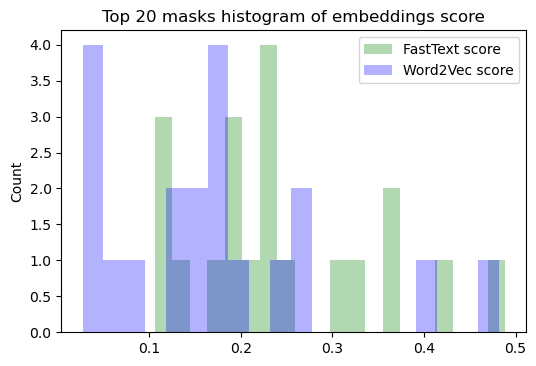

Original word position:  6 ; score:  56.70950698852539
Input:  what can you eat with type 2 diabetes?
['what', 'Ġcan', 'Ġyou', 'Ġeat', 'Ġwith', 'Ġtype', 'Ġ2', '<mask>']
            word   bert ftext  w2vec
0       diabetes  60.86  1.00   1.00
1              ?  57.78  0.06  -2.00
2       Diabetes  56.97  0.78   0.75
3              :  53.76  0.05  -2.00
4              ?  53.49  0.06  -2.00
5         sugars  53.15  0.43   0.36
6          sugar  53.07  0.44   0.26
7        obesity  52.69  0.63   0.65
8          blood  52.66  0.36   0.31
9              D  52.50  0.07   0.11
10       insulin  52.34  0.62   0.53
11   cholesterol  52.23  0.53   0.62
12            ??  52.05  0.00  -2.00
13      diabetic  51.92  0.77   0.75
14             .  51.92  0.02  -2.00
15             A  51.86  0.04   0.00
16  hypertension  51.71  0.68   0.75
17            ?:  51.68  0.00  -2.00
18       disease  51.58  0.57   0.58
19        stress  51.48  0.22   0.19
            word   bert ftext w2vec
0       diabetes  

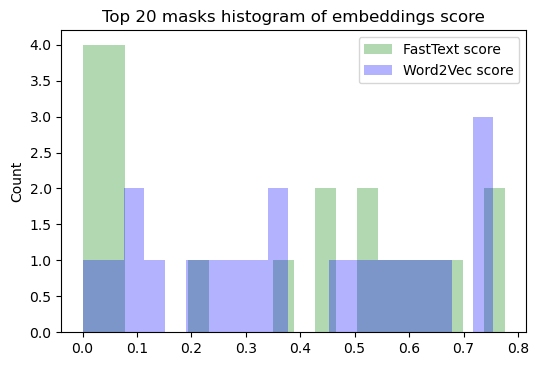

Original word position:  0 ; score:  60.86024475097656


In [135]:
for a in articles:
    do_find(a)